# Intro
- Goal
- Hypothesis
- Data cycle
- Methods we'll use
- Significance

In the U.S. today, six in ten Americans live with at least one [chronic disease](https://www.cdc.gov/chronicdisease/index.htm) and this number only increases with age: over 2/3 of Medicare beneficiaries over 65 have 2 or more chronic diseases, with more than 15% having 6 or [more.](https://www.cdc.gov/pcd/issues/2015/14_0442.htm)

About 61 million people in the U.S., or a fifth of the U.S. population are enrolled in medicare today.

(insert graph from kff later)

Additionally, the U.S. has one of the highest costs of healthcare in the world:

(insert graph)

Individual hospitals pay hundreds of millions on medical and surgical supplies annually. By analyzing data on chronic disease rates and care costs in different regions of the U.S., hospitals can budget their supply costs more effectively to target common conditions, and the government can predict how much medicare and medicaid cost is going to treat these conditions.

Problems like these are well suited to data science, because we can apply computation techniques to gain insight on the prevalence and cost of chronic disease in the U.S. This tutorial will walk through the entire data science pipeline using Chronic Condition data from the U.S. Department of Health and Human Services. We will be collecting and processing data, performing exploratory analysis and visualization through plots and grouping to find trends in chronic diseases in different regions of the U.S., then using machine learning to create a model to interpret and give further insight on how hospitals can predict what chronic diseases will be prevalent in their area.

(insert a photo of the data science lifecycle.)

To work with our data, we'll be using Python. There's a few important Python libraries that we'll use for the different steps. 

Pandas is a library used to manipulate and analyze large amounts of data. Specifically, we're going to use it to store and clean up our data to make it easy to read and to help with the later steps.

Matplotlib is a plotting library which we'll use to show some relationships between demographics in our data. Pyplot is a collection of functions inside Matplotplib that helps us make figures like bar graphs and scatterplots and makes it easy to edit the display of them.

In [172]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Add prose about each library that is used

First, we collect our data. We got our data from [data.gov.](https://data.gov/) It describes specfic chronic conditions based on demographics like age, medicare status, sex, and geographic region. We got this data in the form of a comma-separated values file, which makes it easy to store in a table like a pandas dataframe.

In [173]:
# Import CSV to pandas dataframe
df = pd.read_csv("data.csv")
df.head()

# Add prose about how we retreived the data and its source

,Bene_Geo_Lvl,Bene_Geo_Desc,Bene_Geo_Cd,Bene_Age_Lvl,Bene_Demo_Lvl,Bene_Demo_Desc,Bene_Cond,Prvlnc,Tot_Mdcr_Stdzd_Pymt_PC,Tot_Mdcr_Pymt_PC,Hosp_Readmsn_Rate,ER_Visits_Per_1000_Benes
0,State,Alabama,1.0,All,All,All,Alcohol Abuse,0.0188,25102.3405,23348.6039,0.2413,2184.7557
1,State,Alabama,1.0,65+,Dual Status,Medicare Only,Alcohol Abuse,0.0118,NaN,NaN,NaN,NaN
2,State,Alabama,1.0,<65,Dual Status,Medicare Only,Alcohol Abuse,0.0320,NaN,NaN,NaN,NaN
3,State,Alabama,1.0,All,Dual Status,Medicare Only,Alcohol Abuse,0.0147,NaN,NaN,NaN,NaN
4,State,Alabama,1.0,65+,Dual Status,Medicare and Medicaid,Alcohol Abuse,0.0238,NaN,NaN,NaN,NaN


We have a lot of columns in our data, and the column names aren't especially helpful to the average person to understand. We found a helpful dictionary for the headers [here](https://data.cms.gov/sites/default/files/2020-12/Specific%20Chronic%20Conditions%20Data%20Dictionary.pdf) so we'll rename these columns to make them more readable.

From here, we delete unneccesary data in our dataframe. This could be columns we don't need, like the beneficiary geographic code, rows with too much missing data to be useful for us, and entries that are too specific. We only want the state-wide data, not the county-specific and national information.

In [174]:
# Cleaning the data

# Deleting unneeded columns
df.drop(columns = 'Bene_Geo_Cd', inplace = True)

# Renaming columns
df = df.set_axis(['Geo_Lvl', 'State', 'Age_Lvl', 'Demographic', 'Demographic_Desc', 
                     'Condition', 'Prevalence', 'Medicare_Payment_Standardized', 
                     'Medicare_Payment', 'Hospital_Readmission_Rate', 'ER_Rate_Per_1000'], 
                     axis = 1)

# Deleting rows at end with too much missing data
df.drop(df.tail(21).index, inplace = True)

# Delete county-specific and national enteries
df = df.loc[df['Geo_Lvl'] == 'State']

df

,Geo_Lvl,State,Age_Lvl,Demographic,Demographic_Desc,Condition,Prevalence,Medicare_Payment_Standardized,Medicare_Payment,Hospital_Readmission_Rate,ER_Rate_Per_1000
0,State,Alabama,All,All,All,Alcohol Abuse,0.0188,25102.340500,23348.603900,0.2413,2184.7557
1,State,Alabama,65+,Dual Status,Medicare Only,Alcohol Abuse,0.0118,NaN,NaN,NaN,NaN
2,State,Alabama,<65,Dual Status,Medicare Only,Alcohol Abuse,0.0320,NaN,NaN,NaN,NaN
3,State,Alabama,All,Dual Status,Medicare Only,Alcohol Abuse,0.0147,NaN,NaN,NaN,NaN
4,State,Alabama,65+,Dual Status,Medicare and Medicaid,Alcohol Abuse,0.0238,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
236098,State,Wyoming,65+,All,All,Hypertension,0.4185,14091.718674,16051.028884,NaN,NaN
236099,State,Wyoming,65+,All,All,Ischemic Heart Disease,0.2113,16965.132331,19512.892238,NaN,NaN
236100,State,Wyoming,65+,All,All,Osteoporosis,0.0512,18563.682367,21084.682682,NaN,NaN
236101,State,Wyoming,65+,All,All,Schizophrenia and Other Psychotic Disorders,0.0067,21828.833222,24658.202736,NaN,NaN


Now that our data has been collected and cleaned, we need to get a sense of what trends are visible in our data. We'll be doing some exploratory data analysis by visualizing our data through plots.

First, we want to get a sense of how much each state spends on chronic conditions

In [175]:
# Bar graph of state vs per capita spending

df1 = df[["State", "Medicare_Payment"]]

df1 = df1.dropna(subset=['Medicare_Payment'])

df1 = df1.groupby(['State']).sum()

df1


,Medicare_Payment
State,
Alabama,1.264863e+06
Alaska,1.650902e+06
Arizona,1.474884e+06
Arkansas,1.268369e+06
California,1.912136e+06
Colorado,1.397672e+06
Connecticut,1.700346e+06
Delaware,1.499545e+06
District of Columbia,1.927823e+06


<Axes: xlabel='State'>

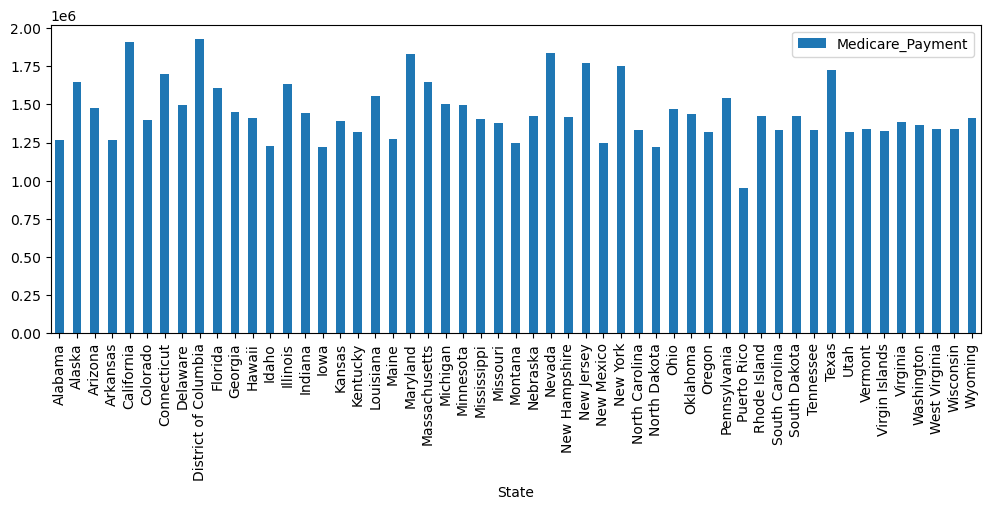

In [176]:
df1.plot.bar(figsize=(12, 4))

In [177]:
# Bar graph of disease vs per capita spending

df2 = df[["Condition", "Medicare_Payment"]]

df2 = df2.dropna(subset=['Medicare_Payment'])

df2 = df2.groupby(['Condition']).sum()

df2

,Medicare_Payment
Condition,
Alcohol Abuse,4.007717e+06
Alzheimer's Disease/Dementia,4.370870e+06
Arthritis,2.642109e+06
Asthma,3.492510e+06
Atrial Fibrillation,5.027974e+06
Autism Spectrum Disorders,1.718904e+06
COPD,4.274726e+06
Cancer,3.688560e+06
Chronic Kidney Disease,3.999802e+06


<Axes: xlabel='Condition'>

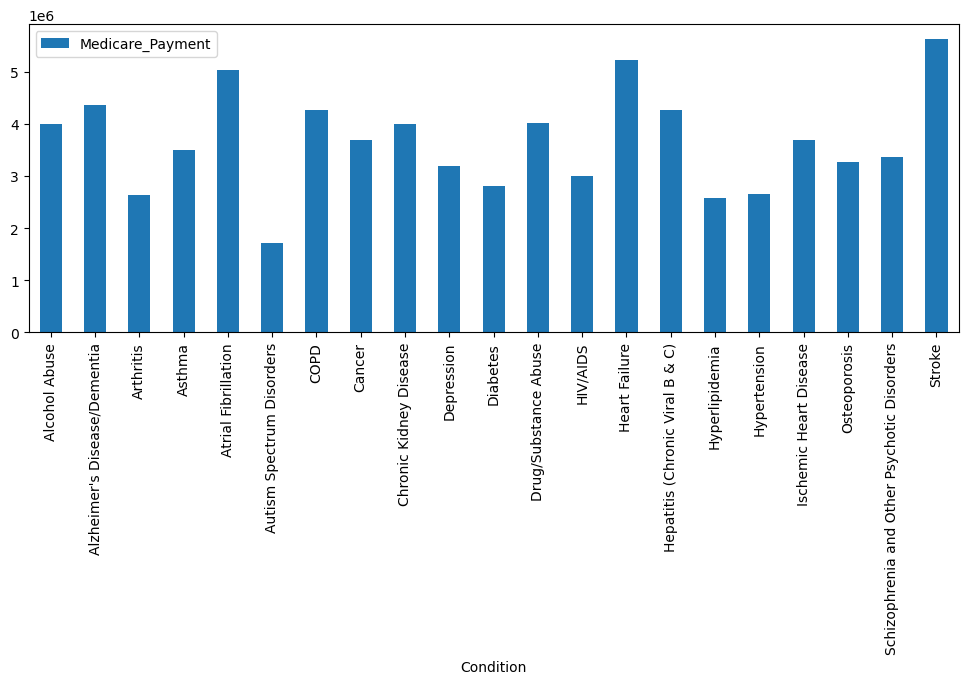

In [178]:
df2.plot.bar(figsize=(12, 4))

In [179]:
# Bar graph of state vs condition

df3 = df[["State", "Prevalence", "Medicare_Payment"]]

df3 = df3.dropna(subset=['Medicare_Payment'])

df3.drop(columns = 'Medicare_Payment', inplace = True)

df3 = df3.groupby(['State']).sum()

df3

,Prevalence
State,
Alabama,9.8964
Alaska,6.5883
Arizona,8.2265
Arkansas,8.9524
California,8.6566
Colorado,7.1760
Connecticut,9.4564
Delaware,9.8540
District of Columbia,8.9326


<Axes: xlabel='State'>

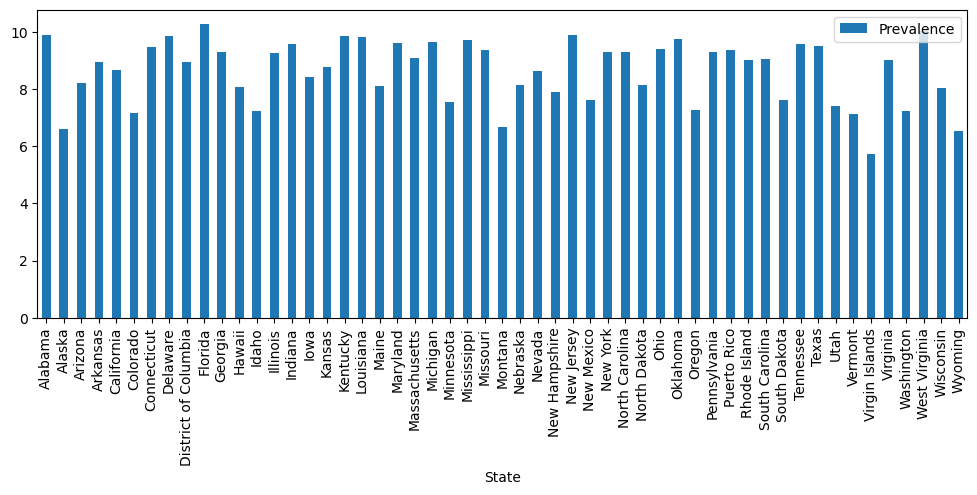

In [180]:
df3.plot.bar(figsize=(12, 4))

In [181]:
# Plotting age vs prevalence for each state

df4 = df[["State", "Age_Lvl", "Prevalence", "Medicare_Payment"]]

df4 = df4.dropna(subset=['Medicare_Payment'])

df4.drop(columns = 'Medicare_Payment', inplace = True)

df4 = df4.drop(df4[df4['Age_Lvl'] == 'All'].index)

df4 = df4.groupby(['State', 'Age_Lvl']).sum()

df4 = df4.reset_index()

df4

,State,Age_Lvl,Prevalence
0,Alabama,65+,3.6085
1,Alabama,<65,2.8433
2,Alaska,65+,2.1822
3,Alaska,<65,2.2187
4,Arizona,65+,2.9118
...,...,...,...
101,West Virginia,<65,3.0279
102,Wisconsin,65+,2.8377
103,Wisconsin,<65,2.4171
104,Wyoming,65+,2.2115


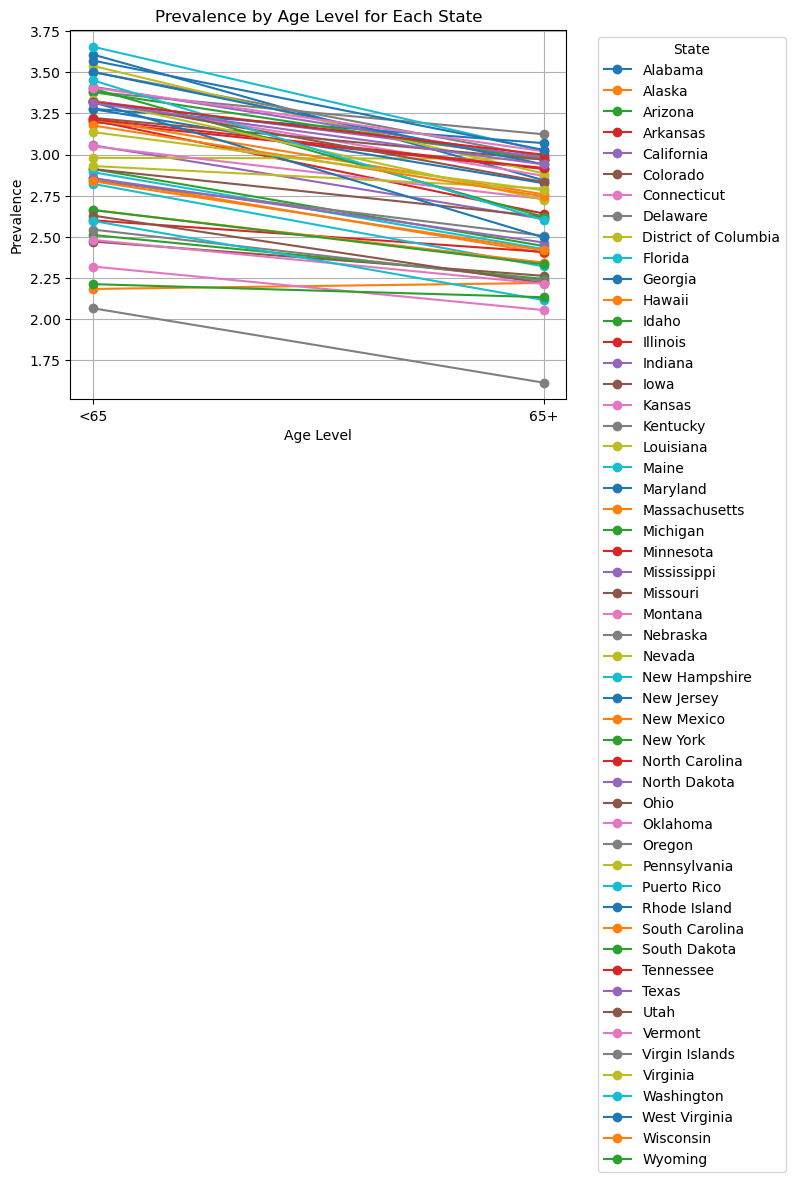

In [182]:
# Set the index to ['State', 'Age_Lvl']
df4.set_index(['State', 'Age_Lvl'], inplace=True)

# Unstack the 'State' index level to pivot the data
df_unstacked = df4['Prevalence'].unstack(level=0)

# Plotting
df_unstacked.plot(kind='line', marker='o')

# Add labels and title
plt.xlabel('Age Level')
plt.ylabel('Prevalence')
plt.title('Prevalence by Age Level for Each State')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(ticks=[0, 1], labels=['<65', '65+'])

# Show plot
plt.show()

In [183]:
# Plotting prevalence vs cost for each state

df5 = df[["State", "Prevalence", "Medicare_Payment"]]

df5 = df5.dropna(subset=['Medicare_Payment'])

df5 = df5.groupby(['State']).sum()

df5 = df5.reset_index()

df5.drop(columns = 'State', inplace = True)

df5 = df5.set_index('Prevalence').sort_index()

df5

,Medicare_Payment
Prevalence,
5.7304,1.324818e+06
6.5453,1.412222e+06
6.5883,1.650902e+06
6.6581,1.249322e+06
7.1312,1.338816e+06
7.1760,1.397672e+06
7.2253,1.225731e+06
7.2408,1.367575e+06
7.2707,1.319042e+06


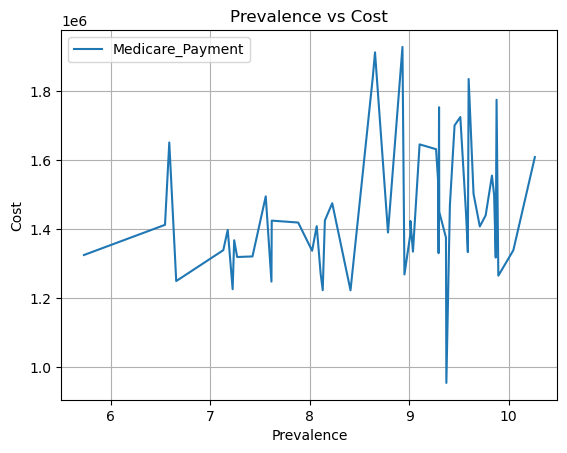

In [184]:
# Plotting
df5.plot()

# Add labels and title
plt.xlabel('Prevalence')
plt.ylabel('Cost')
plt.title('Prevalence vs Cost')
plt.grid(True)

# Show plot
plt.show()

## Decision Tree

In [185]:
# Formatting data

dfDT = df

dfDT.drop(columns = ['Medicare_Payment_Standardized', 'Medicare_Payment', 'Hospital_Readmission_Rate', 'ER_Rate_Per_1000'], inplace = True)

dfDT = dfDT[~dfDT.isin(['All']).any(axis=1)]

dfDT['Age_Lvl'] = dfDT['Age_Lvl'].replace({'<65': 0, '65+': 1})

# Deleting all except sex
dfDT = dfDT[dfDT.isin(['Sex']).any(axis=1)]

dfDT.drop(columns = ['Demographic'], inplace = True)

dfDT.rename(columns={'Demographic_Desc' : 'Sex'}, inplace=True)

dfDT['Sex'] = dfDT['Sex'].replace({'Female': 0, 'Male': 1})

dfDT

C:\Users\ppree\AppData\Local\Temp\ipykernel_13420\1226170036.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfDT['Age_Lvl'] = dfDT['Age_Lvl'].replace({'<65': 0, '65+': 1})


,Geo_Lvl,State,Age_Lvl,Sex,Condition,Prevalence
7,State,Alabama,1,0,Alcohol Abuse,0.0058
8,State,Alabama,0,0,Alcohol Abuse,0.0235
10,State,Alabama,1,1,Alcohol Abuse,0.0232
11,State,Alabama,0,1,Alcohol Abuse,0.0537
20,State,Alabama,1,0,Alzheimer's Disease/Dementia,0.1547
...,...,...,...,...,...,...
15000,State,Wyoming,0,1,Schizophrenia and Other Psychotic Disorders,0.0873
15009,State,Wyoming,1,0,Stroke,0.0225
15010,State,Wyoming,0,0,Stroke,0.0176
15012,State,Wyoming,1,1,Stroke,0.0211


In [186]:
dfDT.drop(columns = 'Geo_Lvl', inplace = True)

categorical_columns = dfDT[['State']].columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(dfDT[['State']])
#one_hot_encoded
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([dfDT, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

#one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out)
df_encoded = df_encoded.dropna()
df_encoded

,Age_Lvl,Sex,Condition,Prevalence,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,...,State_Texas,State_Unknown,State_Utah,State_Vermont,State_Virgin Islands,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
7,1.0,0.0,Alcohol Abuse,0.0058,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,Alcohol Abuse,0.0235,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,1.0,Alcohol Abuse,0.0232,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,1.0,Alcohol Abuse,0.0537,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,0.0,Alzheimer's Disease/Dementia,0.1547,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,0.0,1.0,Drug/Substance Abuse,0.1021,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4531,1.0,0.0,HIV/AIDS,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4532,0.0,0.0,HIV/AIDS,0.0027,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4534,1.0,1.0,HIV/AIDS,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [187]:

# encode conditions
#conditions = df_encoded['Condition'].unique()
#print(conditions)
df_encoded["Condition"] = df_encoded["Condition"].replace({'Alcohol Abuse': 0, "Alzheimer's Disease/Dementia": 1, 'Arthritis': 2, 'Asthma': 3,
 'Atrial Fibrillation': 4,  'Autism Spectrum Disorders': 4,  'COPD': 5, 'Cancer': 6, 
 'Chronic Kidney Disease': 7, 'Depression': 8, 'Diabetes': 9,  'Drug/Substance Abuse': 10, 
 'HIV/AIDS': 11,  'Heart Failure': 12,  'Hepatitis (Chronic Viral B & C)': 13, 
 'Hyperlipidemia': 14,  'Hypertension': 15, 'Ischemic Heart Disease': 16, 'Osteoporosis': 17,
 'Schizophrenia and Other Psychotic Disorders': 18, 'Stroke': 19})
df_encoded

,Age_Lvl,Sex,Condition,Prevalence,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,...,State_Texas,State_Unknown,State_Utah,State_Vermont,State_Virgin Islands,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
7,1.0,0.0,0,0.0058,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0,0.0235,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,1.0,0,0.0232,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,1.0,0,0.0537,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,0.0,1,0.1547,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,0.0,1.0,10,0.1021,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4531,1.0,0.0,11,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4532,0.0,0.0,11,0.0027,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4534,1.0,1.0,11,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


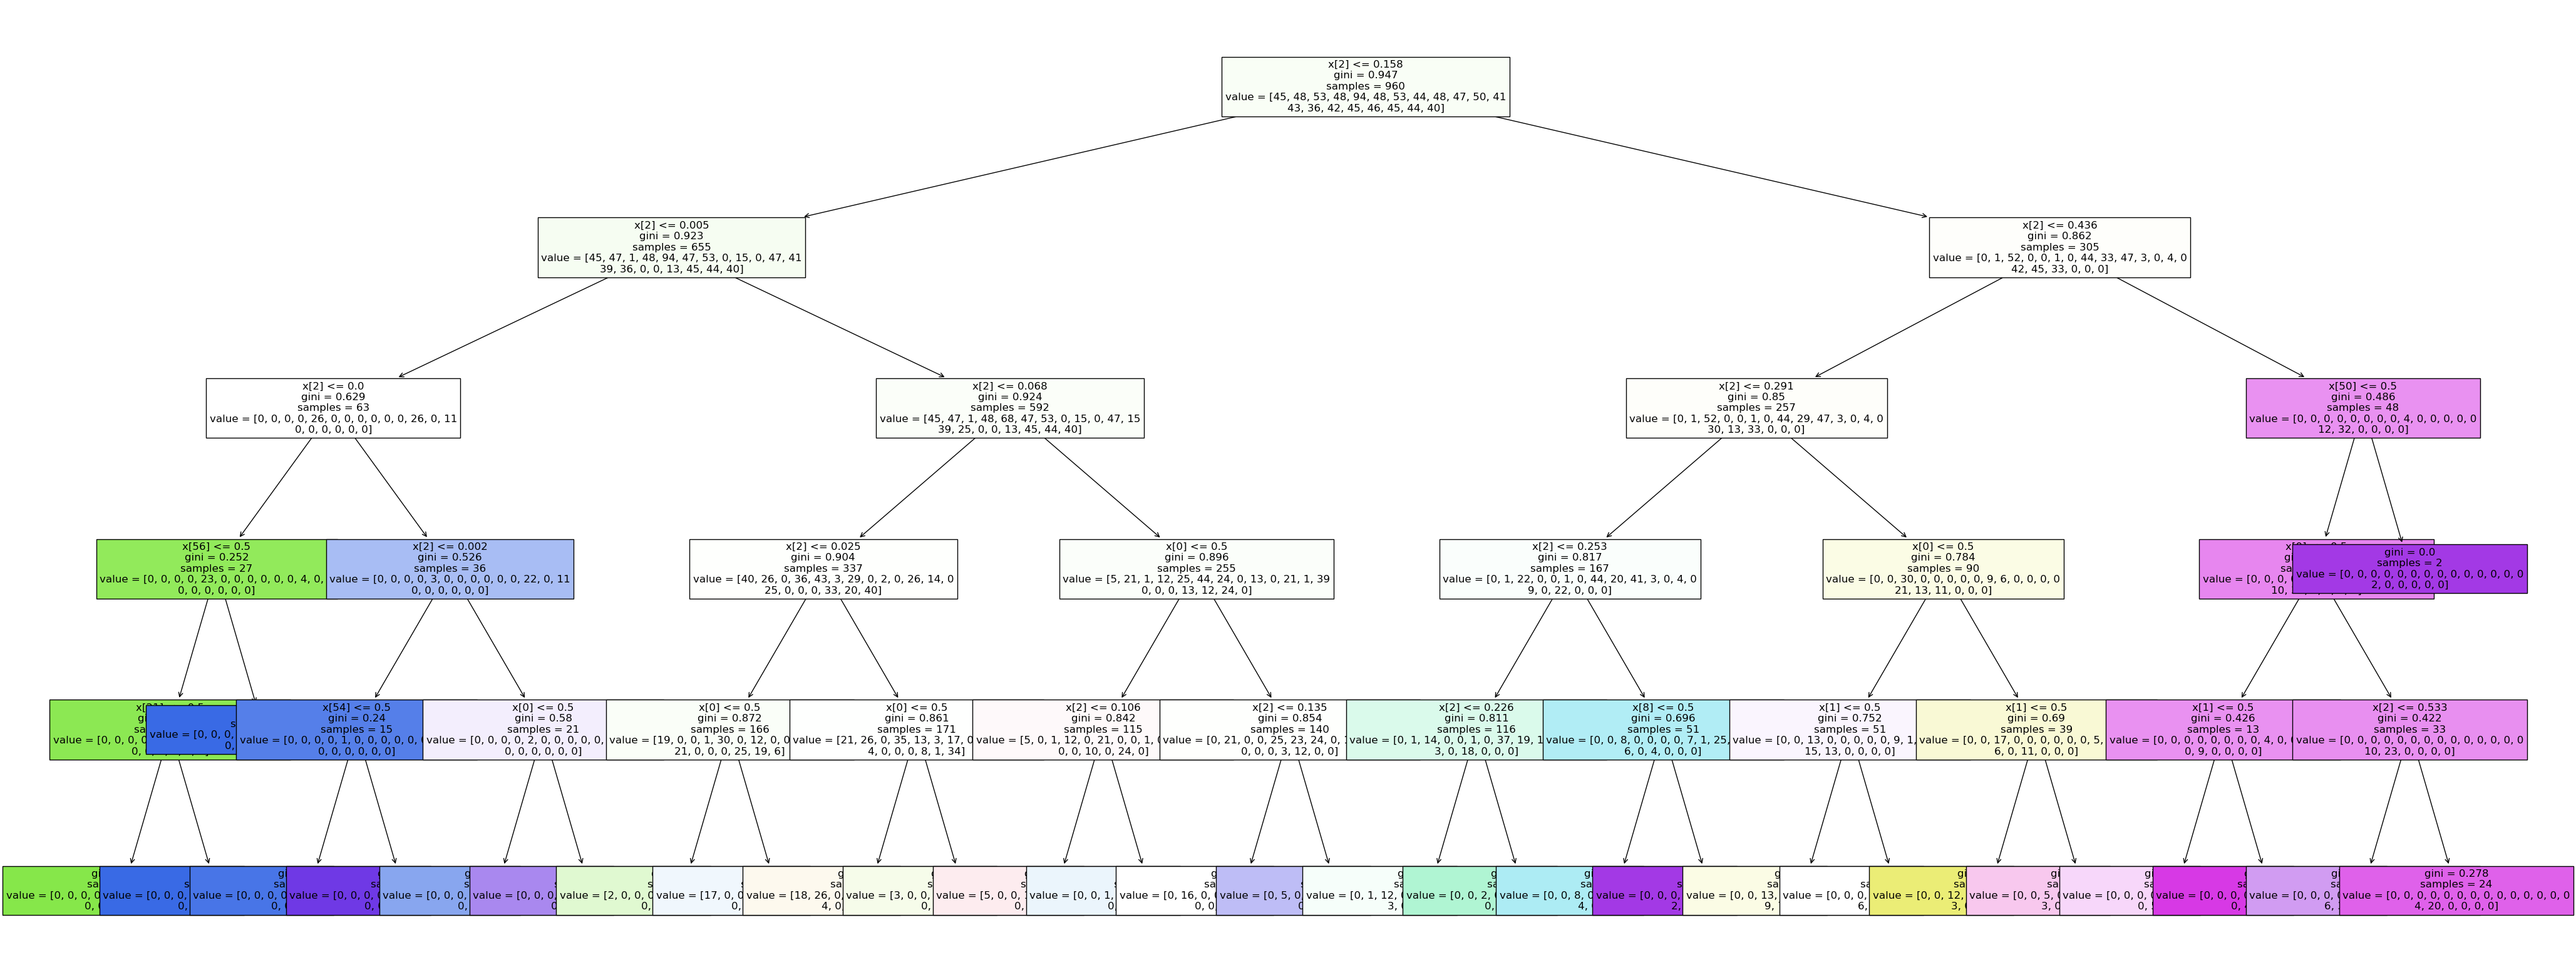

In [208]:
y = df_encoded["Condition"]
X = df_encoded.drop(columns ='Condition')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(50,20))
tree.plot_tree(clf, fontsize=12, filled=True)
plt.show()

In [203]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.32038834951456313
